In [336]:
%pylab inline
%run params.py

import matplotlib.pyplot as plt
import pandas as pd
import random
import os
from scipy.stats import pearsonr
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from plotting_functions import *
from scipy.stats import ks_2samp

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [343]:
# Load data
dataset = pd.read_csv(os.path.join(DATAPATH, "constraint", "autosomal_perlocus_estimates.bed"))

# 4A Expression by tissue

In [344]:
# Look at expression by tissue
gtex = pd.read_csv(os.path.join(DATAPATH,"strsets","GTEx_Analysis_v6p_RNA-seq_RNA-SeQCv1.1.8_gene_median_rpkm.gct.gz"),
                  skiprows=2, sep="\t")
exprcols = [item for item in gtex.columns if item not in ["Description","Name"]]
gtex["gene"] = gtex["Description"]

setdata = pd.read_csv(os.path.join(DATAPATH, "strsets", "lobSTR_ref_GRCh37_coding_genes.bed.gz"), sep="\t", names=["chrom","start","end","gene"])
setdata = pd.merge(setdata, dataset, on=["chrom","start"]).drop_duplicates()
data = pd.merge(setdata, gtex, on=["gene"])
exprmatrix = data.loc[:,exprcols]

In [345]:
col="zscore_1"

corr = []
pvals = []
means = []
nums = []
kspvals = []
kspvals_ctrl = []
threshold = 5 # top X% of expressed genes

for tissue in exprcols:
    r = pearsonr(data[data[tissue]>0][col], data[data[tissue]>0][tissue])
    corr.append(r[0])
    pvals.append(r[1])
    means.append(np.mean(data[data[tissue]>0][col]))
    nums.append(data[data[tissue]>0].shape[0])
    
    # zscores for top 10%
    cutoff = np.percentile(data[tissue], [threshold])[0]
    zhigh = data[data[tissue]>cutoff][col]
    zlow = data[data[tissue]<=cutoff][col]
    kspvals.append(ks_2samp(zhigh, zlow)[1])
    
    # Repeat, with expression shuffled
    rexpr = data[tissue].copy()
    random.shuffle(rexpr)
    zhigh = data[rexpr>cutoff][col]
    zlow = data[rexpr<=cutoff][col]
    kspvals_ctrl.append(ks_2samp(zhigh, zlow)[1])    
    
cdata = pd.DataFrame({"tissue": exprcols, "corr": corr, "pval": pvals, "meanz": means,"num":nums,
                      "ksp":kspvals, "ksp_ctrl": kspvals_ctrl})
cdata["corr2"] = cdata["corr"].apply(lambda x: x**2)
cdata = cdata[["tissue","corr","corr2","pval","meanz","num","ksp","ksp_ctrl"]]

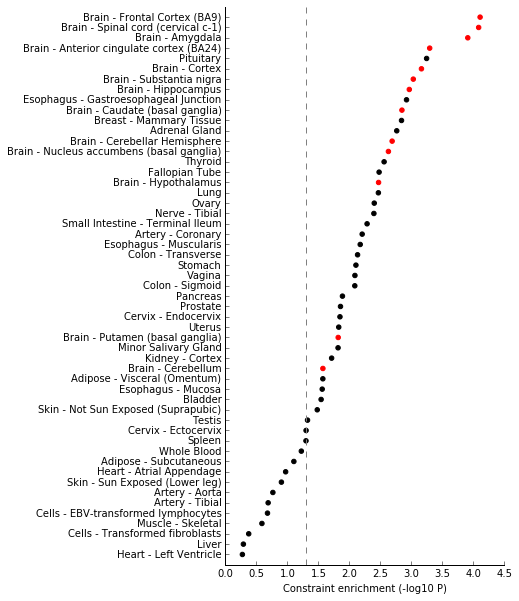

In [346]:
colors = {}
for tissue in exprcols:
    if "Brain" in tissue: colors[tissue] = "red"

cdata["color"] = cdata["tissue"].apply(lambda x: colors.get(x, "black"))
cdata = cdata.sort("ksp", ascending=False)
cdata["order"] = range(cdata.shape[0])
fig = plt.figure()
fig.set_size_inches((5,10))
ax = fig.add_subplot(111)
ax.scatter(np.log10(cdata["ksp"])*-1, cdata["order"], color=cdata["color"])
ax.axvline(x=-1*np.log10(0.05), linestyle="dashed", color="gray")
ax.set_ylim(bottom=-1, top=cdata.shape[0])
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.set_yticks(cdata["order"])
ax.set_yticklabels(cdata["tissue"]);
ax.set_xlabel("Constraint enrichment (-log10 P)")
fig.savefig(os.path.join(PLOTDIR, "Figure4_ConstraintExpression.pdf"))

In [ ]:
cdata = cdata.sort("ksp_ctrl")
ctrl = -1*np.log10(cdata["ksp_ctrl"])
exp2 = -1*np.log10(sorted(np.random.uniform(size=cdata.shape[0])))
cdata = cdata.sort("ksp")
exp = -1*np.log10(sorted(np.random.uniform(size=cdata.shape[0])))
obs = -1*np.log10(cdata["ksp"])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(exp, obs, color=cdata["color"])
ax.scatter(exp2, ctrl, color="gray")
ax.plot([0,2],[0,2], color="black", linestyle="dashed")
ax.set_xlim(left=0, right=max(exp)+0.5)
ax.set_ylim(bottom=0, top=max(obs)+0.5)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.set_xlabel("Expected pval", size=15)
ax.set_ylabel("Observed pval", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12);

In [184]:
# Load data and example loci and gtex
loci = pd.read_csv(os.path.join(DATAPATH, "strsets", "loci_for_figure.bed"), names=["chrom","start","end","marker"], sep="\t")
loci = pd.merge(dataset, loci, on=["chrom","start","end"])

def GetColor(x):
    if x["marker"] == "CODIS": return "black"
    else: return "red"

def GetMarker(x):
    if x["marker"] == "CODIS": return "CODIS"
    else: return "DISEASE:%s"%x["marker"]
        
loci = loci.sort("marker")
loci["color"] = loci.apply(lambda x: GetColor(x), 1)
loci["marker"] = loci.apply(lambda x: GetMarker(x), 1)
loci = loci.sort("marker")
loci = loci[loci["start"] != 45582231]

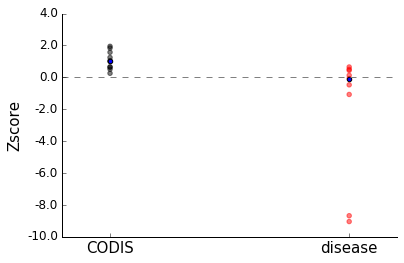

In [185]:
loci["xcoord"] = loci["color"].apply(lambda x: [0,1][x=="red"])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(loci["xcoord"], loci["zscore_1"], color=list(loci.color), alpha=0.5);
ax.scatter([0,1],[np.median(loci[loci["color"]=="black"]["zscore_1"]),
                 np.median(loci[loci["color"]=="red"]["zscore_1"])])
ax.set_xticks([0,1])
ax.set_xticklabels(["CODIS","disease"], size=15);
ax.set_ylabel("Zscore", size=15)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.axhline(0, linestyle="dashed", color="gray")
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);

In [186]:
loci.sort("zscore_1")[["marker","chrom","start","ml_mu","ml_mu_stderr","pred_mu_1","pred_mu_2","zscore_1","zscore_2","filter1"]]

,marker,chrom,start,ml_mu,ml_mu_stderr,pred_mu_1,pred_mu_2,zscore_1,zscore_2,filter1
19,DISEASE:RUNX2,6,45390419,-7.674329,-9.209195,-4.552772,-6.254413,-9.043946,-1.746948,True
9,DISEASE:HOXD13,2,176957786,-7.674249,-9.209099,-4.678655,-6.657197,-8.678909,-1.251297,True
20,DISEASE:RUNX2,6,45390487,-5.940301,1.591492,-4.678696,-6.657149,-1.071794,0.516391,True
5,DISEASE:JPH3,16,87637889,-3.795438,0.245596,-3.614204,-3.319052,-0.469026,-0.573153,False
15,DISEASE:ATXN7,3,63898361,-4.083734,0.349867,-4.051631,-4.640428,-0.075597,0.655226,False
6,DISEASE:SCA6,19,13318673,-3.651243,0.263161,-3.701066,-3.584069,0.127055,-0.080559,False
8,CODIS,2,1493425,-4.034426,0.365839,-4.145719,-4.876467,0.258036,0.987199,False
3,DISEASE:ATXN3,14,92537355,-3.848303,1.631509,-4.377105,-5.726692,0.439139,1.331035,True
1,DISEASE:ATN1,12,7045880,-3.209443,0.243354,-3.406301,-2.645478,0.510390,-0.678787,False
21,CODIS,7,83789542,-3.077558,0.396328,-3.307210,-2.190394,0.516532,-1.031859,True


In [342]:
category="1"
col="diff_1"
autism_genes = set(autism[autism["category"].apply(lambda x: int(x.strip("S"))<=int(category))]["Gene Symbol"])
coding["autism"] = coding.apply(lambda x: x["gene"] in autism_genes, 1)
autsum = coding.groupby(["autism","gene"], as_index=False).agg({col: min, "start": len}).sort("autism", ascending=False)
autsum[autsum["autism"]]

,autism,gene,start,diff_1
1282,True,SYNGAP1,1,-3.009027
1281,True,POGZ,1,-2.797779
1280,True,ASXL3,1,-2.700990
1279,True,ASH1L,2,-3.133359
1278,True,ARID1B,6,-3.048733


In [341]:
coding[coding["gene"]=="ASH1L"]

,chrom,start,end,gene,ml_mu,ml_mu_stderr,motif,pred_mu_1,pred_mu_se_1,pred_mu_2,pred_mu_se_2,pred_mu_3,filter1,filter2,zscore_1,zscore_2,diff_1,diff_2,diff_3,autism
199,1,155532207,155532265,ASH1L,-7.674221,488.579756,CCG,-4.540862,0.488134,-6.268608,1.149477,-6.10714,True,False,-0.009070,-0.004069,-3.133359,-1.405613,-1.567081,True
203,1,155532591,155532629,ASH1L,-5.794540,3.113046,AGG,-4.540862,0.488134,-6.268608,1.149477,-6.10714,True,False,-0.562653,0.202030,-1.253678,0.474068,0.312600,True


S Ks_2sampResult(statistic=0.23491995425957685, pvalue=0.52505332265472648)
1 Ks_2sampResult(statistic=0.28262910798122065, pvalue=0.74651501062655301)
2 Ks_2sampResult(statistic=0.29490196078431374, pvalue=0.42323837682690418)
3 Ks_2sampResult(statistic=0.1955831608005521, pvalue=0.3183227537682537)
4 Ks_2sampResult(statistic=0.13787397405348162, pvalue=0.72984887866299353)
5 Ks_2sampResult(statistic=0.25736134934248145, pvalue=0.40758809735295531)


,category,num_false,num_true,se_false,se_true,zscores_false,zscores_true,diff
0,S,1272,11,3.886137,3.708710,-5.553203,-6.149635,-0.596432
1,1,1278,5,3.886867,3.145398,-5.553425,-6.808662,-1.255237
2,2,1275,8,3.888575,3.262864,-5.556692,-5.817249,-0.260557
3,3,1260,23,3.865406,4.820547,-5.566247,-5.123911,0.442336
4,4,1259,24,3.883641,3.943003,-5.564747,-5.221018,0.343729
5,5,1272,11,3.886597,3.700506,-5.558308,-5.559311,-0.001002


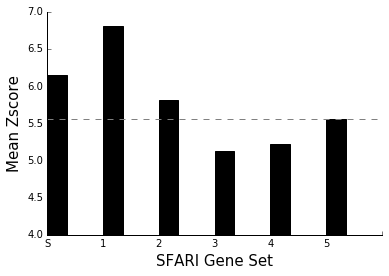

In [339]:
# Autism   https://gene.sfari.org/autdb/GSGeneList.do?c=2
coding = pd.read_csv(os.path.join(DATAPATH, "strsets", "lobSTR_ref_GRCh37_coding_genes.bed.gz"), sep="\t", names=["chrom","start","end","gene"])
coding = pd.merge(coding, dataset, on=["chrom","start","end"]).drop_duplicates()
autism = (pd.read_csv(os.path.join(DATAPATH, "strsets","autism_sfari_genes_bycategory.csv")))
autism["gene"] = autism["Gene Symbol"]
def GetInt(x):
    try:
        return int(x)
    except: return 0

categories = []
zscores_true = []
zscores_false = []
num_true = []
num_false = []
se_true = []
se_false = []

col = "zscore_1"
for category in ["S","1","2","3","4","5"]:
    #if category in ["S", ""]:
    autism_genes = set(autism[autism["category"].apply(lambda x: category in str(x))]["Gene Symbol"])
    #else:
    #    autism_genes = set(autism[autism["category"].apply(lambda x: int(x.strip("S"))<=int(category))]["Gene Symbol"])
    coding["autism"] = coding.apply(lambda x: x["gene"] in autism_genes, 1)
    autsumx = coding.groupby(["autism","gene"], as_index=False).agg({col: min, "start": len}).sort("autism", ascending=False)
    autsumx[col+"2"] = autsumx[col]
    autsum = autsumx.groupby("autism", as_index=False).agg({col: np.mean, col+"2": lambda x: np.sqrt(np.var(x)), "start": len})
    categories.append(category)
    zscores_true.append(autsum[autsum["autism"]][col].values[0])
    zscores_false.append(autsum[~autsum["autism"]][col].values[0])
    num_true.append(autsum[autsum["autism"]]["start"].values[0])
    num_false.append(autsum[~autsum["autism"]]["start"].values[0])
    se_true.append(autsum[autsum["autism"]][col+"2"].values[0])
    se_false.append(autsum[~autsum["autism"]][col+"2"].values[0])
    print category, ks_2samp(autsumx[autsumx["autism"]][col], autsumx[~autsumx["autism"]][col])

autsetdata = pd.DataFrame({"category": categories, "zscores_true": zscores_true, "zscores_false": zscores_false,
             "num_true": num_true, "num_false": num_false,
                          "se_true": se_true, "se_false": se_false})
autsetdata["diff"] = autsetdata["zscores_true"]-autsetdata["zscores_false"]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(autsetdata.shape[0]), -1*autsetdata["zscores_true"], width=0.35, color="black")
ax.axhline(-1*autsetdata["zscores_false"].values[0], linestyle="dashed", color="gray")
ax.set_xticklabels(autsetdata["category"]);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.set_ylim(bottom=4, top=7);
ax.set_xlabel("SFARI Gene Set", size=15)
ax.set_ylabel("Mean Zscore", size=15);

autsetdata